In [1]:
%matplotlib inline

import json
from math import radians, sqrt, tan
import avlwrapper as avl

# AVL
For a full description of AVL, please read the [documentation](https://web.mit.edu/drela/Public/web/avl/avl_doc.txt).

# Creating the geometry
We're going to make an aircraft with a wing and horizontal & vertical tail
The wing will have a span of 12, with an aspect ratio of 8.
The horizontal tail an area of 6 with a span of 5 and
the vertical tail an area of 4 with an aspect ratio of 2.

## Number of panels
The number of chordwise and spanwise panels is an important parameter.
For now, we're going to put 20 spanwise panels and 12 panels in chordwise direction.
More panels does not necessarily lead to better results.

## The wing
The wing consists of two sections, the root and tip.
First we create the wing sections, which are used in the wing.

Since $A=\frac{b^2}{S}$ and 
$S=b\cdot c_r\cdot\frac{1}{2}(1+\lambda)$,
$c_r=\frac{2b}{A(1+\lambda)}$

In [2]:
wing_span = 12
wing_aspect_ratio = 8
wing_taper = 0.3
wing_le_sweep = radians(20)
wing_dihedral = radians(4)

wing_root_chord = 2 * wing_span / (wing_aspect_ratio * (1+wing_taper))
wing_tip_chord = wing_root_chord * wing_taper

wing_root_le_pnt = avl.Point(0, 0, 0)
wing_tip_le_pnt = avl.Point(x=0.5 * wing_span * tan(wing_le_sweep),
                            y=0.5 * wing_span,
                            z=0.5 * wing_span * tan(wing_dihedral))

root_section = avl.Section(leading_edge_point=wing_root_le_pnt,
                           chord=wing_root_chord,
                           airfoil=avl.NacaAirfoil('2414'))
tip_section = avl.Section(leading_edge_point=wing_tip_le_pnt,
                          chord=wing_tip_chord,
                          airfoil=avl.NacaAirfoil('2410'))

# y_duplicate=0.0 duplicates the wing over a XZ-plane at Y=0.0
wing = avl.Surface(name='wing',
                   n_chordwise=12,
                   chord_spacing=avl.Spacing.cosine,
                   n_spanwise=20,
                   span_spacing=avl.Spacing.cosine,
                   y_duplicate=0.0,
                   sections=[root_section, tip_section])

## The tail surfaces
The tail surfaces will have an elevator and rudder.
These will be created as `Control` objects which will be given to the sections.

In [3]:
ht_span = 5
ht_area = 6
ht_taper = 0.4
ht_sweep = radians(24)
ht_dihedral = radians(6)

ht_root_chord = 2 * ht_area / (ht_span * (1+ht_taper))
ht_tip_chord = ht_root_chord * ht_taper

elevator = avl.Control(name='elevator',
                       gain=1.0,
                       x_hinge=0.6,
                       duplicate_sign=1)

ht_root_le_pnt = avl.Point(8, 0, 0.5)
ht_tip_le_pnt = avl.Point(x=ht_root_le_pnt.x + 0.5*ht_span*tan(ht_sweep),
                          y=0.5*ht_span,
                          z=ht_root_le_pnt.z + 0.5*ht_span*tan(ht_dihedral))

root_section = avl.Section(leading_edge_point=ht_root_le_pnt,
                           chord=ht_root_chord,
                           airfoil=avl.NacaAirfoil('0012'),
                           controls=[elevator])
tip_section = avl.Section(leading_edge_point=ht_tip_le_pnt,
                          chord=ht_tip_chord,
                          airfoil=avl.NacaAirfoil('0012'),
                          controls=[elevator])
horizontal_tail = avl.Surface(name='horizontal_tail',
                              n_chordwise=12,
                              chord_spacing=avl.Spacing.cosine,
                              n_spanwise=20,
                              span_spacing=avl.Spacing.cosine,
                              y_duplicate=0.0,
                              sections=[root_section, tip_section])

In [4]:
vt_area = 4
vt_aspect_ratio = 2
vt_taper = 0.3
vt_sweep = radians(30)

vt_span = sqrt(vt_area * vt_aspect_ratio)
vt_root_chord = 2 * vt_area / (vt_span * (1+vt_taper))
vt_tip_chord = vt_root_chord * vt_taper

rudder = avl.Control(name='rudder',
                     gain=1.0,
                     x_hinge=0.7,
                     duplicate_sign=-1)

vt_root_le_pnt = avl.Point(8, 0, 0.5)
vt_tip_le_pnt = avl.Point(x=vt_root_le_pnt.x + vt_span*tan(vt_sweep),
                          y=0,
                          z=vt_root_le_pnt.z + vt_span)

root_section = avl.Section(leading_edge_point=vt_root_le_pnt,
                           chord=vt_root_chord,
                           airfoil=avl.NacaAirfoil('0012'),
                           controls=[rudder])
tip_section = avl.Section(leading_edge_point=vt_tip_le_pnt,
                          chord=vt_tip_chord,
                          airfoil=avl.NacaAirfoil('0012'),
                          controls=[rudder])
vertical_tail = avl.Surface(name='vertical_tail',
                            n_chordwise=12,
                            chord_spacing=avl.Spacing.cosine,
                            n_spanwise=20,
                            span_spacing=avl.Spacing.cosine,
                            y_duplicate=0.0,
                            sections=[root_section, tip_section])

## Creating the geometry object
We're going to use the wing area, M.A.C and span as the references which AVL will use the normalise the results.

Let's run all analyses at a Mach number of 0.4.

In [5]:
mach = 0.4

wing_mac = ((2 * wing_root_chord/3) * 
            (1 + wing_taper+wing_taper**2) / 
            (1+wing_taper))

wing_area = wing_span**2 / wing_aspect_ratio

def mac_le_pnt(root_chord, tip_chord, root_pnt, tip_pnt):
    pnt = ((2*root_chord*root_pnt[dim] +
            root_chord*tip_pnt[dim] + 
            tip_chord*root_pnt[dim] +
            2*tip_chord*tip_pnt[dim]) / 
           (3*(root_chord+tip_chord))
           for dim in range(3))
    return avl.Point(*pnt)

le_pnt = mac_le_pnt(wing_root_chord, wing_tip_chord,
                    wing_root_le_pnt, wing_tip_le_pnt)

ref_pnt = avl.Point(x=le_pnt.x + 0.25*wing_mac,
                    y=le_pnt.y, z=le_pnt.z)

aircraft = avl.Geometry(name='aircraft',
                        reference_area=wing_area,
                        reference_chord=wing_mac,
                        reference_span=wing_span,
                        reference_point=ref_pnt,
                        mach=mach,
                        surfaces=[wing, horizontal_tail, vertical_tail])

## Plotting the geometry
If Ghostscript is installed and the Python packages numpy and matplotlib are available, we can plot the geometry
in this notebook. Otherwise, we'll have to view it inside AVL.

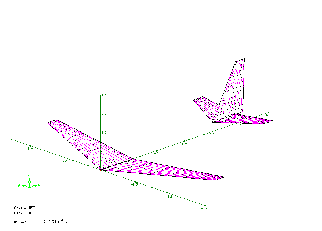

In [6]:
# create a session with only the geometry
session = avl.Session(geometry=aircraft)

# check if we have ghostscript
if 'gs_bin' in session.config.settings:
    img = session.save_geometry_plot()[0]
    avl.show_image(img)
else:
    session.show_geometry()

# Running Analyses

## Simple analysis
First, let's run the aircraft at an angle-of-attack of $\alpha=0^{\circ}$

In [7]:
# create a function for showing the Trefftz plot, since we'll be using it more often
def show_treffz(session):
    if 'gs_bin' in session.config.settings:
        images = session.save_trefftz_plots()
        for img in images:
            avl.show_image(img)
    else:
        for idx, _ in enumerate(session.cases):
            session.show_trefftz_plot(idx+1) # cases start from 1

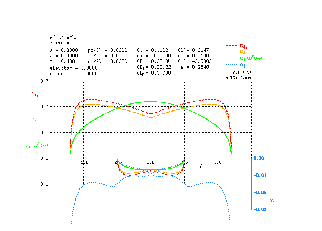

CL = 0.16923


In [8]:
simple_case = avl.Case(name='zero_aoa',
                       alpha=0)
session = avl.Session(geometry=aircraft, cases=[simple_case])

show_treffz(session)

# results are in a dictionary
result = session.run_all_cases()
print("CL = {}".format(result['zero_aoa']['Totals']['CLtot']))

## Trimming at a prescribed lift-coefficient
This example shows how to set dependent variables and using controls.

Since $C_L$ is a function of $\alpha$ we need to tell AVL to change $\alpha$
to achieve a certain $C_L$. In addition, we're telling AVL to change the `elevator`
control to achieve zero pitching moment ($C_m$).

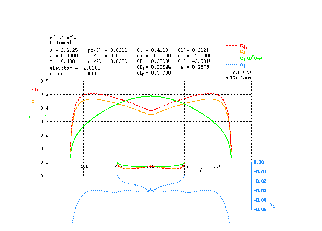

In [9]:
# set CL to 0.4
cl_param = avl.Parameter(name='alpha', setting='CL', value=0.4)

# trim with elevator
trim_param = avl.Parameter(name='elevator', setting='Cm', value=0.0)

trim_case = avl.Case(name='trimmed',
                     alpha=cl_param,
                     elevator=trim_param)

session = avl.Session(geometry=aircraft, cases=[trim_case])

show_treffz(session)

## Case parameters
Let's see what parameters we can set and what dependent variables we can use as settings.

In addition, the case states are listed. These can also be set (for example Mach number, density, etc.),
but note that some states are dependent on an analysis result will be overwritten.
Please read the AVL documentation for more info.

In [10]:
print("Parameters:")
print(", ".join(avl.Case.CASE_PARAMETERS.keys()))

print("\nSettings:")
print(", ".join(avl.Case.VALID_SETTINGS))

print("\nStates:")
print(", ".join(avl.Case.CASE_STATES.keys()))

Parameters:
alpha, beta, roll_rate, pitch_rate, yaw_rate

Settings:
rb/2V, beta, qc/2V, CY, Cl, pb/2V, alpha, CL, Cn, Cm

States:
alpha, beta, roll_rate, pitch_rate, yaw_rate, CL, cd_p, bank, elevation, heading, mach, velocity, density, gravity, turn_rad, load_fac, X_cg, Y_cg, Z_cg, mass, Ixx, Iyy, Izz, Ixy, Iyz, Izx, visc_CL_a, visc_CL_u, visc_CM_a, visc_CM_u


## Create a lot of cases
With `create_sweep_cases` its possible to generate a lot of cases,
for example to perform a parameter sweep.

In this example we're going to generate cases for varying angle-of-attack and elevator setting.
For example, to trim the aircraft in another program.

The angle-of-attack will vary from -6 to 6, and the elevator will vary from -15 to 15.

In [14]:
base_case = avl.Case(name='sweep')

alphas = list(range(-6, 7, 2))
elevators = list(range(-15, 16, 3))
all_cases = avl.create_sweep_cases(base_case=base_case,
                                   parameters=[{'name': 'alpha',
                                                'values': alphas},
                                               {'name': 'elevator',
                                                'values': elevators}])
session = avl.Session(geometry=aircraft, cases=all_cases)

# THIS WILL FAIL!
try:
    session.run_all_cases()
except avl.session.InputError:
    print("OOPS!")

OOPS!


AVL can only handle 25 cases at once, so lets create partitions.

In [12]:
partitions = avl.partitioned_cases(all_cases)
results = {}
for partition in partitions:
    session = avl.Session(geometry=aircraft, cases=partition)
    results.update(session.run_all_cases())
    
# Write everything to json
with open('all_cases.json', 'w') as f:
    f.write(json.dumps(results))